In [1]:
%matplotlib inline
import pandas as pd
import re
from lxml import etree 
from bz2file import BZ2File
import bz2
import codecs
import xml
import glob
import os
import bs4
import collections
import itertools
import math
import networkx as nx
import community
import pickle
from collections import defaultdict, Counter
from bs4 import BeautifulSoup
from pattern.nl import parsetree, pprint, singularize, pluralize
from pattern.metrics import readability
from xml import parsers
import xml.parsers.expat
from xml.etree import cElementTree as ET
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import timeit

import treetagger

In [2]:
def parse_troonrede(f):
    '''Read a troonrede file, extract all text and output a list of lists, 
    each element is a paragraph containing a list of sentences,
    each sentence is parsed.'''
    soup= BeautifulSoup(open(f).read())
    ourdiv=soup.find('div', id="post-content") 
    ourpars= [parsetree(p.text, lemmata=True, Relations=True) for p in ourdiv.findAll('p')[1:-1]]
    return ourpars

# this applies step 2 to all troonredes 
def parse_corpus(folder):
    alltroonredes= glob.glob(os.path.join(folder, '*.html'))
    troonredes={}
    for troonrede in alltroonredes:
        key= troonrede.split('\\')[1].replace('.html','')
        value= parse_troonrede(troonrede)
        troonredes[key]=value
    return troonredes

parsedtroonredes= parse_corpus('files')
print "Troonrede parsing"

Troonrede parsing


C:\Users\niek\Anaconda2\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [16]:
treetagger.help()

AttributeError: 'module' object has no attribute 'help'

In [3]:
'''Gehele corpus met lemmatiseren'''
def processText(parsedcorpus):
    wordsPerPara= [list([ w.lemma for s in p for w in s.nouns])  for p in parsedcorpus  ]
    return wordsPerPara

tekst= {k:processText(parsedtroonredes[k]) for k in parsedtroonredes}

In [4]:
'''Alle gelemmatiseerde woorden en hoevaak ze voorkomen in het corpus'''
lemmaDict = {}
for troonrede in sorted(tekst):
    for paragraph in tekst[troonrede]:
        for word in paragraph:
            try:
                if str(word) in lemmaDict:
                    lemmaDict[str(word)] += 1
                else:
                    lemmaDict[str(word)] = 1
            except:
                pass

In [5]:
'''Gebruikt de dictionary van gelemmatiseerde woorden om een dictionary te maken van alle mogelijke combinaties van 2 woorden'''
wordlist = []
fullCombiDict = {}
for word in lemmaDict:
    word = re.sub(r'[^\w]', '', word)
    if len(word) > 2:
        wordlist.append(word)
for combi in itertools.combinations(sorted(wordlist),2):
    fullCombiDict[combi] = 0

In [6]:
'''Per jaar de hoeveelheid paragrafen, zinnen en woorden'''
redes = {}
dataPerYear = {}
for troonrede in parsedtroonredes:
    year = troonrede
    paragraphs = 0
    sentences = 0
    words = 0
    syllables = 0
    rede = []
    for paragraph in parsedtroonredes[troonrede]:
        paragraphs += 1
        sentences += len(paragraph)
        for sentence in paragraph:
            words += len(sentence)
            for word in sentence:
                if word.string == "." or word.string == ",":
                    rede.append(word.string)
                else:
                    rede.append(word.string)
                    try:
                        syllables += syllablesCount(word.string)
                    except:
                        pass
    redes[year] = rede            
    info = [paragraphs,sentences,words,syllables]
    dataPerYear[year] = info
print "- dataPerYear bevat per jaar: aantal paragrafen, aantal zinnen, aantal woorden en aantal lettergrepen in de gehele troonrede"
print "- redes bevat per jaar de gehele troonrede als tekst"

- dataPerYear bevat per jaar: aantal paragrafen, aantal zinnen, aantal woorden en aantal lettergrepen in de gehele troonrede
- redes bevat per jaar de gehele troonrede als tekst


In [7]:
paragraphCount = 0
for year in dataPerYear:
    paragraphCount += dataPerYear[year][0]
print paragraphCount

2491


In [8]:
'''Bouwen van de collocatie dataframe voor alle troonredes'''
yearCombiDict = {}
for troonrede in tekst:
    combiDict = {}
    for paragraph in tekst[troonrede]:
        words = []
        for word in paragraph:
            word = re.sub(r'[^\w]', '', word)
            if len(word) > 2:
                words.append(word)
        for combi in itertools.combinations(sorted(words),2):
            if combi in fullCombiDict:
                fullCombiDict[combi] += 1
            else:
                pass
            if combi in combiDict:
                combiDict[combi] += 1
            else:
                combiDict[combi] = 1
    yearCombiDict[troonrede] = combiDict

In [19]:
%%time
wordParcount = {}
combiParcount = {}

for troonrede in sorted(tekst):
    for paragraph in tekst[troonrede]:
        for word1 in sorted(paragraph):
            if len(word1.encode('utf-8')) > 1:
                if word1.encode('utf-8') in wordParcount:
                    wordParcount[word1.encode('utf-8')] += 1
                else:
                    wordParcount[word1.encode('utf-8')] = 1
                for word2 in sorted(paragraph):
                    if len(word2.encode('utf-8')) > 1:
                        if word1.encode('utf-8') < word2.encode('utf-8'):
                            if (word1.encode('utf-8'),word2.encode('utf-8')) in combiParcount:
                                combiParcount[word1.encode('utf-8'),word2.encode('utf-8')] += 1
                            else:
                                combiParcount[word1.encode('utf-8'),word2.encode('utf-8')] = 1
                
for item in wordParcount:
    wordParcount[item] = wordParcount[item]/float(paragraphCount)
for item in combiParcount:
    combiParcount[item] = combiParcount[item]/float(paragraphCount)

Wall time: 2.31 s


In [29]:
x = 0
for key in sorted(combiParcount,key=combiParcount.__getitem__,reverse=True):
    if x < 10:
        print key,combiParcount[key]
        x += 1
    else:
        break

('jaar', 'regering') 0.115214773183
('land', 'regering') 0.107185869129
('mens', 'regering') 0.0730630268968
('jaar', 'land') 0.0662384584504
('ontwikkeling', 'regering') 0.0658370132477
('edel', 'mogenden') 0.0642312324368
('onderwijs', 'regering') 0.0590124448013
('beleid', 'regering') 0.0570052187876
('maatregel', 'regering') 0.0562023283822
('regering', 'zorg') 0.054997992774


In [10]:
'''Functie om P(w) te berekenen'''
def findW(word):
    return float(wordParcount[word])

'''Functie om P(w,c) te berekenen'''
def findWC(W,C):
    try:
        return float(combiParcount[W,C])
    except:
        return 0.0

'''Functie om I(w,c) te berekenen'''
def findI(W1,W2):
    total = 0.0
    for word in wordParcount:
        if word != W1 and word != W2:
            part1 = findWC(W1,word)
            part2 = findW(W1)
            part3 = findW(word)
            if part1 != 0 and (part2*part3) != 0: 
                check = math.log(part1/(part2*part3))
                if check > 0:
                    total += check
    return total
                
'''Functie om de score S(w1,w2) te bepalen'''
def score(W1,W2):
    score = 0.0
    part1 = findI(W1,W2)
    if part1 == 0:
        return score
    part2 = findI(W2,W1)
    if part2 == 0:
        return score
    score = min(part1,part2)/part1
    return score

# alvast code maken voor figuur 4 en kijken hoe die figuur gemaakt kan worden via pandas

In [31]:
'''Berekenen van de proximity score over alle collocaties'''
def networkBuilder ():
    output = {}
    for combi in combiParcount:
        if combi[0] != combi[1]:
            weight = score(combi[0],combi[1])
            if weight > 0:
                output[combi] = weight
    return output

In [32]:
'''Netwerk bouwen over enkel de 1000 grootste collocaties'''
def smallerBuilder ():
    output = {}
    x = 0
    for combi in sorted(combiParcount,key=combiParcount.__getitem__,reverse=True):
        if combi[0] != combi[1]:
            if x < 1000:
                weight = score(combi[0],combi[1])
                if weight > 0:
                    output[combi] = weight
                    x += 1
            else:
                return output
    return output

In [12]:
%%time
findI("wet","kabinet")

Wall time: 16 ms


133.09772560573873

In [33]:
%%time
netwerkDict = smallerBuilder()

Wall time: 20.6 s


In [34]:
print netwerkDict

{('lidstaat', 'regering'): 1.0, ('aandacht', 'samenwerking'): 0.2559443592949348, ('aantal', 'onderwijs'): 0.4423415872603923, ('aard', 'den'): 1.0, ('maatregel', 'probleem'): 0.5069430813136473, ('jaar', 'uitgaf'): 0.17653393174310253, ('den', 'een'): 0.4610123410911013, ('den', 'zeeg'): 0.01002825738405024, ('land', 'sector'): 0.24861747727071906, ('kennis', 'onderwijs'): 1.0, ('regering', 'termijn'): 0.3079093852828393, ('handel', 'landbouw'): 0.7838006412020202, ('partner', 'regering'): 1.0, ('betrekking', 'nederland'): 0.9395022769461184, ('criminaliteit', 'misdaad'): 0.5738883416869945, ('overheid', 'werkgelegenheid'): 0.10749823100757448, ('regering', 'volk'): 0.2014062617460619, ('jaar', 'sector'): 0.20088285994735047, ('betrekking', 'jaar'): 1.0, ('scholing', 'werk'): 0.525348134322875, ('behoud', 'jaar'): 1.0, ('economie', 'herstel'): 0.9576015893478546, ('belang', 'samenwerking'): 0.23728800002682823, ('voorziening', 'zorg'): 0.41463823094766783, ('bijdrage', 'regering'): 0.

In [40]:
'''Dataframe van gegevens voor de troonredes per jaar'''
df = pd.DataFrame(dataPerYear)
yearFrame = df.transpose()
yearFrame.columns = ['Paragrafen', 'Zinnen', 'Woorden', 'Lettergrepen']
framefile = open("frame.txt","wb")
pickle.dump( yearFrame, framefile )
framefile.close()

In [41]:
'''Opslaan van het netwerk dictionary naar pickle'''
netwerkfile = open("netwerkFull.txt", 'wb')
pickle.dump( netwerkDict, netwerkfile )
netwerkfile.close()

In [42]:
#Openen van een opgeslagen dictionary vanuit pickle
netwerkDict = pickle.load( open( "netwerkFull.txt", "rb" ) )

In [37]:
'''Vergroten van de graphs zodat ze duidelijker zijn'''
%pylab inline
pylab.rcParams['figure.figsize'] = 16, 12

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


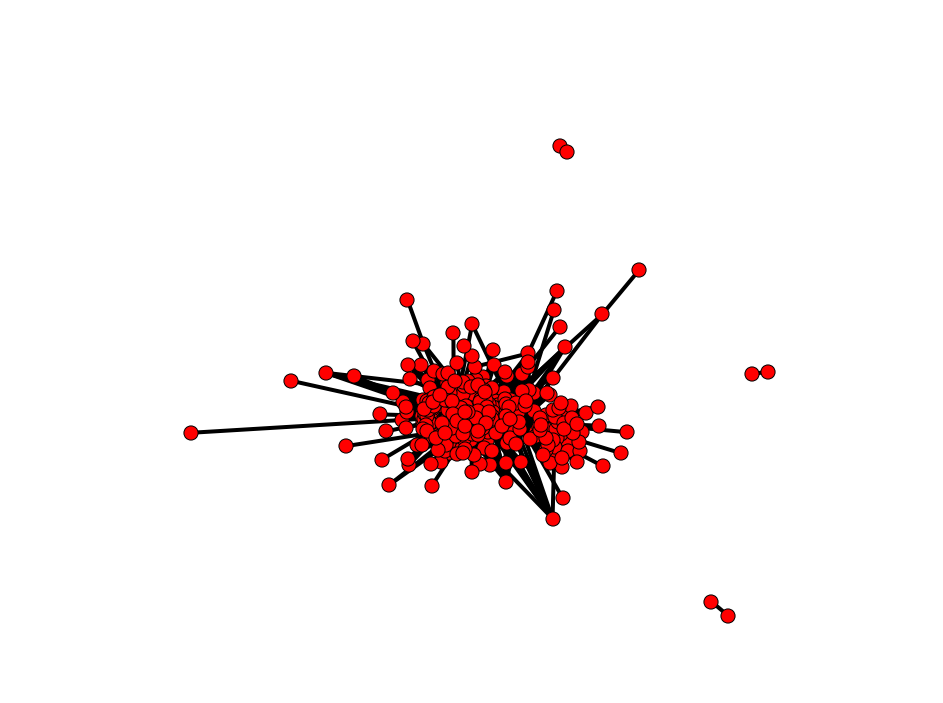

In [39]:
'''Creeëren van de weighted graph vanuit de gevonden similarity scores'''
G = nx.Graph()
for item in netwerkDict:
    G.add_edge(item[0],item[1],weight=netwerkDict[item])
    
pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=200)

# edges
nx.draw_networkx_edges(G,pos, width=4)

# labels
#nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.figure(figsize=(1000,1000))
plt.show() # display